<a href="https://colab.research.google.com/github/Sumukhfintech/Investment-Strategies-Comparison/blob/main/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import scipy.optimize as sco
import yfinance as yf
import seaborn as sns
import warnings
from scipy import stats
import warnings

In [ ]:
data = pd.read_csv('/content/histretSP.csv')
print(data.dtypes)
returns = data.iloc [:,1:]

Year             int64
S&P 500        float64
T-Bill         float64
T-Bond         float64
Baa Bond       float64
Real Estate    float64
Gold           float64
dtype: object


In [ ]:
returns.describe()

,S&P 500,T-Bill,T-Bond,Baa Bond,Real Estate,Gold
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.116578,0.033385,0.048587,0.069537,0.044181,0.065542
std,0.195508,0.030075,0.079517,0.077123,0.062416,0.207722
min,-0.438375,0.000327,-0.178282,-0.156808,-0.119956,-0.325986
25%,-0.011935,0.008508,0.008063,0.023922,0.009206,-0.005910
50%,0.145211,0.029350,0.032822,0.063554,0.038540,0.000969
75%,0.259666,0.050642,0.085448,0.113901,0.075237,0.137430
max,0.525633,0.140362,0.328145,0.290525,0.241017,1.265487


In [ ]:
def port_vol(x, r):
    return r.dot(x).std()

def port_mean(x, r):
    return r.dot(x).mean()

tret = np.linspace(returns.mean().min(), returns.mean().max(), 30)

res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol, # minimize portfolio volatility
        x0=np.ones(returns.shape[1]) / returns.shape[1], # initial portfolio weights of 1/n
        args=(returns), # additional arguments to fun, in order
        bounds=[(0, 1) for c in returns.columns], # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=returns) - t} # constrains portfolio mean return to the target return
        )
    )
    res_ef.append(_)


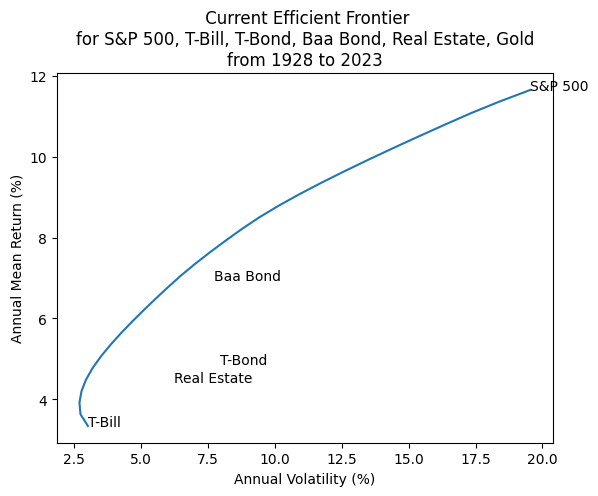

In [ ]:
ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)

ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annual Mean Return (%)')
plt.xlabel('Annual Volatility (%)')
plt.title(
    f' Current Efficient Frontier' +
    f'\nfor {", ".join(returns.columns)}'
    f'\nfrom {data["Year"].min()} to {data["Year"].max()}'
)

for t, x, y in zip(
    returns.columns,
    returns.std().mul(100),
    returns.mean().mul(100)
):
    plt.annotate(text=t, xy=(x, y))

plt.show()

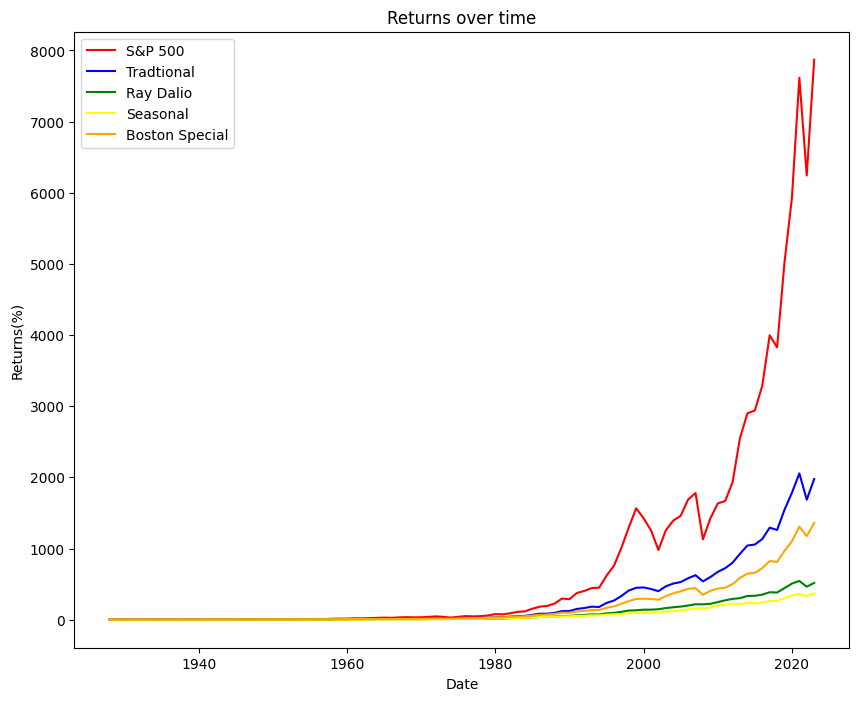

In [ ]:
#Portfolio 1
data['SPcumreturns'] = (1+data['S&P 500']).cumprod() - 1

#Portfolio 2
data['Tradinv'] = (0.6*data['S&P 500'] + 0.4*data['T-Bond'])
data['Tradcuminv'] = (1+data['Tradinv']).cumprod() - 1

#Portfolio 3
data['seasoninv'] = (0.25*data['S&P 500'] + 0.25*data['T-Bond'] + 0.25*data['Gold'] + 0.25*data['T-Bill'])
data['seasoncuminv'] = (1+data['seasoninv']).cumprod() - 1

#Portfolio 4
data['rayinv'] = (0.30*data['S&P 500'] + 0.55 * data['T-Bond'] + 0.075*data['Gold'] + 0.075*data['Real Estate'])
data['raycuminv'] = (1+data['rayinv']).cumprod() - 1

#Portfolio 5
data['bostoninv'] = (0.45*data['S&P 500'] + 0.25 * data['Baa Bond'] + 0.30*data['Real Estate'])
data['bostoncuminv'] = (1+data['bostoninv']).cumprod() - 1

#Setting up plots
plt.figure(figsize=(10, 8))
plt.plot(data['Year'], data['SPcumreturns'], label='S&P 500', color='red')
plt.plot(data['Year'], data['Tradcuminv'], label='Tradtional', color='blue')
plt.plot(data['Year'], data['raycuminv'], label='Ray Dalio', color='green')
plt.plot(data['Year'], data['seasoncuminv'], label='Browne', color='yellow')
plt.plot(data['Year'], data['bostoncuminv'], label='Boston Special', color='orange')

#Making The plot
plt.title('Returns over time')
plt.xlabel('Date')
plt.ylabel('Returns(%)')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
portreturns = data[['bostoninv','S&P 500', 'Tradinv', 'seasoninv', 'rayinv']]
portreturns.describe()

,bostoninv,S&P 500,Tradinv,seasoninv,rayinv
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.083099,0.116578,0.089382,0.066023,0.069926
std,0.101674,0.195508,0.122245,0.073081,0.075064
min,-0.260922,-0.438375,-0.273261,-0.153678,-0.164738
25%,0.019866,-0.011935,0.010629,0.019806,0.022113
50%,0.096890,0.145211,0.109187,0.061195,0.072551
75%,0.157030,0.259666,0.168961,0.112247,0.110518
max,0.272899,0.525633,0.328539,0.389483,0.253877


In [ ]:
with warnings.catch_warnings():
  warnings.simplefilter(action='ignore', category=FutureWarning)
  ff = pd.DataFrame(pdr.DataReader(name='F-F_Research_Data_Factors', data_source='famafrench', start='1900')[1].div(100))

ff = ff.reset_index()
ff = ff.drop(columns = ['SMB','HML'])
print(ff.dtypes)
print(ff.columns)
ff['Year'] = ff['Date'].dt.year
##Add market-rf, rf to make Mkt column
ff['Market'] = ff['Mkt-RF'] + ff['RF']
ff = ff[ff['Year'].isin(data['Year'])]
# # Calculate the mean and standard deviation for the 'RF' column across all years
mean_rf = ff['RF'].mean()
std_dev_rf = ff['RF'].std()
ff

Date      period[A-DEC]
Mkt-RF          float64
RF              float64
dtype: object
Index(['Date', 'Mkt-RF', 'RF'], dtype='object')


,Date,Mkt-RF,RF,Year,Market
1,1928,0.3539,0.0356,1928,0.3895
2,1929,-0.1954,0.0475,1929,-0.1479
3,1930,-0.3123,0.0241,1930,-0.2882
4,1931,-0.4511,0.0107,1931,-0.4404
5,1932,-0.0939,0.0096,1932,-0.0843
...,...,...,...,...,...
92,2019,0.2828,0.0215,2019,0.3043
93,2020,0.2366,0.0045,2020,0.2411
94,2021,0.2356,0.0004,2021,0.2360
95,2022,-0.2160,0.0143,2022,-0.2017


In [ ]:
##Asumming Rf is the T-Bill data(Fama French doesn't have yearly data and this is 3 month bill annualized)
sharpe_ratios = {}
for portfolio in portreturns.columns:
    excess_return = portreturns[portfolio] - mean_rf
    sharpe_ratio = excess_return.mean() / excess_return.std()
    sharpe_ratios[portfolio] = sharpe_ratio

var_95 = {}
for portfolio in portreturns.columns:
    var_95[portfolio] = np.percentile(portreturns[portfolio], 5)

##Assuming S&P 500 is the market benchmark as it's inclusive of dividends
beta_values = {}
for portfolio in portreturns.columns:
    # Regress portfolio returns against market returns
    market_returns = ff['Mkt-RF']
    portfolio_returns = portreturns[portfolio]
    beta, alpha, r_value, p_value, std_err = stats.linregress(market_returns, portfolio_returns)
    beta_values[portfolio] = beta

treynor_ratios = {}
for portfolio in portreturns.columns:
    excess_return = portreturns[portfolio] - mean_rf
    treynor_ratio = excess_return.mean() / beta_values[portfolio]
    treynor_ratios[portfolio] = treynor_ratio


summary_stats = pd.DataFrame({
    'Sharpe Ratio': sharpe_ratios,
    'VaR 95%': var_95,
    'Beta': beta_values,
    'Treynor Ratio': treynor_ratios
})

summary_stats.T

,bostoninv,S&P 500,Tradinv,seasoninv,rayinv
Sharpe Ratio,0.492364,0.427298,0.460904,0.451338,0.491407
VaR 95%,-0.098473,-0.227554,-0.134161,-0.036912,-0.045860
Beta,0.474730,0.940027,0.560131,0.206978,0.274424
Treynor Ratio,0.105450,0.088870,0.100589,0.159362,0.134416


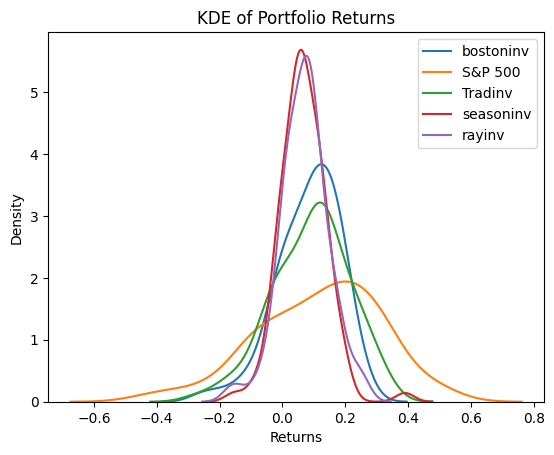

In [ ]:
for column in portreturns.columns:
    sns.kdeplot(portreturns[column], label=column)

plt.title('KDE of Portfolio Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.show()

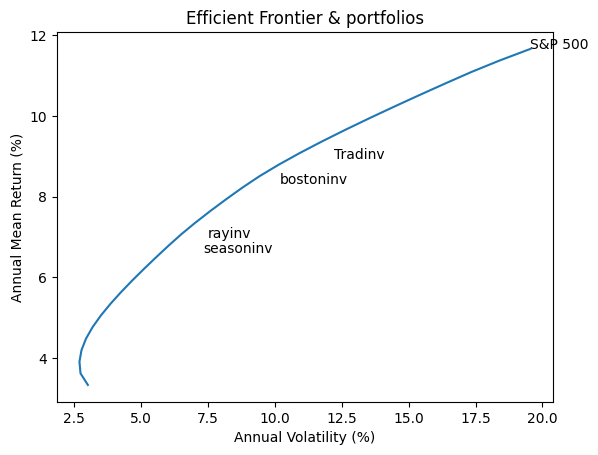

In [ ]:
ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annual Mean Return (%)')
plt.xlabel('Annual Volatility (%)')
plt.title(
    f'Efficient Frontier & portfolios'
)

for t, x, y in zip(
    portreturns.columns,
    portreturns.std().mul(100),
    portreturns.mean().mul(100)
):
    plt.annotate(text=t, xy=(x, y))

plt.show()

In [ ]:
# Calculate expected returns and covariance matrix for the assets
expected_returns = returns.mean()
cov_matrix = returns.cov()

# Define the objective function (negative Sharpe Ratio)
def negative_sharpe_ratio(weights, expected_returns, cov_matrix, rf):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility
    return -sharpe_ratio  # We negate to maximize via minimization (because maximize is not there in scipy)

# Optimization using Sequential Least Squares Programming (SLSQP)
result = sco.minimize(fun = negative_sharpe_ratio,
                      x0 = np.array([1 / len(returns.columns)] * len(returns.columns)), ##Initial guess
                      args=(expected_returns, cov_matrix, mean_rf),
                      method='SLSQP',
                      bounds= tuple((0, 1) for _ in range(len(returns.columns))), ##Limit portfolio search
                      constraints= ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}) ##Constraints such that weights sum upto 1
                      )

# Output the optimal weights
optimal_weights = result.x

# Displaying results
print("Optimal Portfolio Weights:")
for asset, weight in zip(returns.columns, optimal_weights):
    print(f"{asset}: {weight:.2%}")


Optimal Portfolio Weights:
S&P 500: 14.99%
T-Bill: 0.00%
T-Bond: 0.00%
Baa Bond: 52.20%
Real Estate: 24.64%
Gold: 8.17%


In [ ]:
optimal_return = np.dot(optimal_weights, expected_returns)
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

# Calculate the Sharpe Ratio
optimal_sharpe_ratio = (optimal_return - mean_rf) / optimal_volatility

print(f"Optimal Portfolio Return: {optimal_return:.2%}")
print(f"Optimal Portfolio Volatility: {optimal_volatility:.2%}")
print(f"Optimal Portfolio Sharpe Ratio: {optimal_sharpe_ratio:.2f}")

Optimal Portfolio Return: 7.00%
Optimal Portfolio Volatility: 6.38%
Optimal Portfolio Sharpe Ratio: 0.58


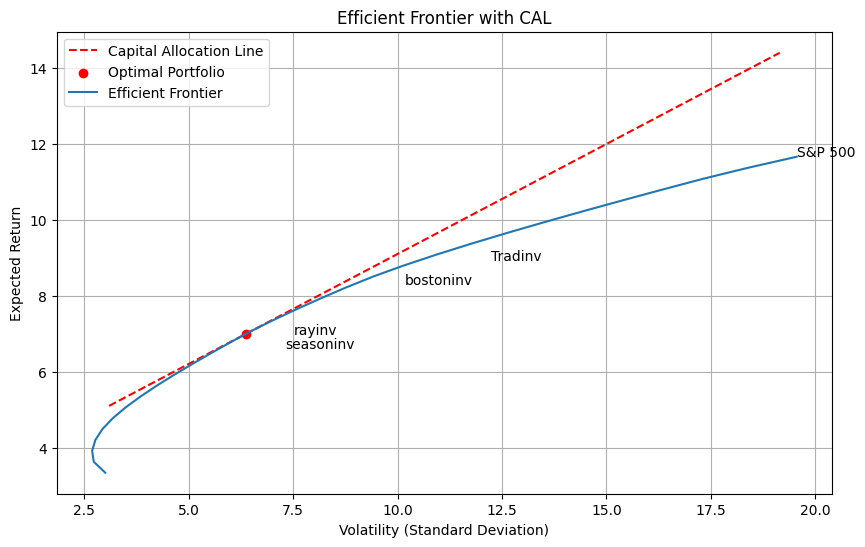

In [ ]:
# Generate x values for plotting the CAL
x_range = np.linspace(std_dev_rf, optimal_volatility * 3, 500)  # Extend beyond the optimal portfolio's volatility

# Calculate y values for the CAL
y_cal = mean_rf + optimal_sharpe_ratio * x_range

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_range*100, y_cal*100, 'r--', label='Capital Allocation Line')
plt.scatter(optimal_volatility*100, optimal_return*100, color='red', label='Optimal Portfolio')  # Mark the optimal portfolio

# Replot the Efficient Frontier
ef.mul(100).plot(x='tvol', y='tret', ax=plt.gca(), legend=False, label ='Efficient Frontier')

# Re-plot the portfolio points and annotations
for t, x, y in zip(portreturns.columns, portreturns.std().mul(100), portreturns.mean().mul(100)):
    plt.annotate(text=t, xy=(x, y))

plt.title('Efficient Frontier with CAL')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def map_year_to_decade(year):
        return str ((year // 10) * 10)

# Apply the function to the 'year' column and create a new 'decade' column
data['Decade'] = data['Year'].apply(map_year_to_decade)
data_1930 = data.loc[data['Decade'] == '1930', ['S&P 500', 'Tradinv']]
data_1930_i = data.loc[data['Decade'] == '1930', ['S&P 500', 'T-Bill', 'T-Bond', 'Baa Bond', 'Gold', 'Real Estate']]
data_1980 = data.loc[data['Decade'] == '1980' ,['seasoninv']]
data_1980_i = data.loc[data['Decade'] == '1980', ['S&P 500', 'T-Bill', 'T-Bond', 'Baa Bond', 'Gold', 'Real Estate']]
data_2010 = data.loc[data['Decade'] == '2010', ['rayinv', 'bostoninv']]
data_2010_i = data.loc[data['Decade'] == '2010', ['S&P 500', 'T-Bill', 'T-Bond', 'Baa Bond', 'Gold', 'Real Estate']]

In [ ]:
def port_vol(x, r):
    return r.dot(x).std()

def port_mean(x, r):
    return r.dot(x).mean()

tret = np.linspace(data_1930_i.mean().min(), data_1930_i.mean().max(), 30)

res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol, # minimize portfolio volatility
        x0=np.ones(data_1930_i.shape[1]) / data_1930_i.shape[1], # initial portfolio weights of 1/n
        args=(data_1930_i), # additional arguments to fun, in order
        bounds=[(0, 1) for c in data_1930_i.columns], # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=data_1930_i) - t} # constrains portfolio mean return to the target return
        )
    )
    res_ef.append(_)


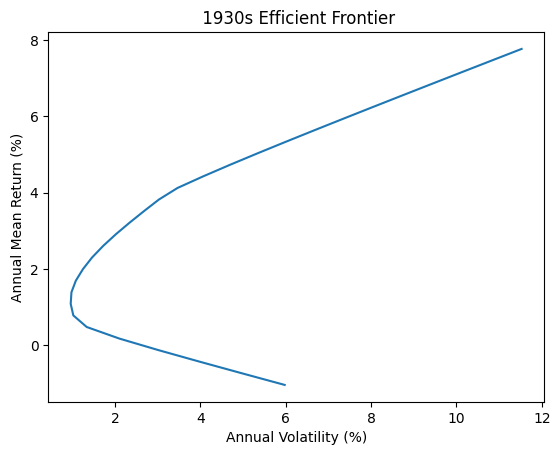

In [ ]:
ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)

ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annual Mean Return (%)')
plt.xlabel('Annual Volatility (%)')
plt.title(
    f' 1930s Efficient Frontier'
)

for t, x, y in zip(
    data_1930.columns,
    data_1930.std().mul(100),
    data_1930.mean().mul(100)
):
    plt.annotate(text=t, xy=(x, y))

plt.show()

In [ ]:
def port_vol(x, r):
    return r.dot(x).std()

def port_mean(x, r):
    return r.dot(x).mean()

tret = np.linspace(data_1980_i.mean().min(), data_1980_i.mean().max(), 30)

res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol, # minimize portfolio volatility
        x0=np.ones(data_1980_i.shape[1]) / data_1980_i.shape[1], # initial portfolio weights of 1/n
        args=(data_1980_i), # additional arguments to fun, in order
        bounds=[(0, 1) for c in data_1980_i.columns], # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=data_1980_i) - t} # constrains portfolio mean return to the target return
        )
    )
    res_ef.append(_)


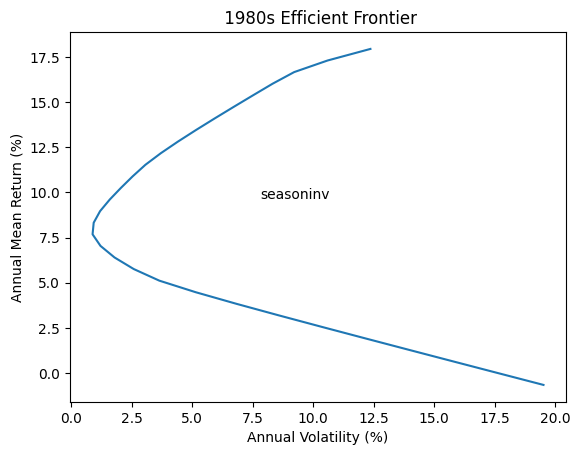

In [ ]:
ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)

ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annual Mean Return (%)')
plt.xlabel('Annual Volatility (%)')
plt.title(
    f' 1980s Efficient Frontier'
)

for t, x, y in zip(
    data_1980.columns,
    data_1980.std().mul(100),
    data_1980.mean().mul(100)
):
    plt.annotate(text=t, xy=(x, y))

plt.show()

In [ ]:
def port_vol(x, r):
    return r.dot(x).std()

def port_mean(x, r):
    return r.dot(x).mean()

tret = np.linspace(data_2010_i.mean().min(), data_2010_i.mean().max(), 30)

res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol, # minimize portfolio volatility
        x0=np.ones(data_2010_i.shape[1]) / data_2010_i.shape[1], # initial portfolio weights of 1/n
        args=(data_2010_i), # additional arguments to fun, in order
        bounds=[(0, 1) for c in data_2010_i.columns], # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=data_2010_i) - t} # constrains portfolio mean return to the target return
        )
    )
    res_ef.append(_)


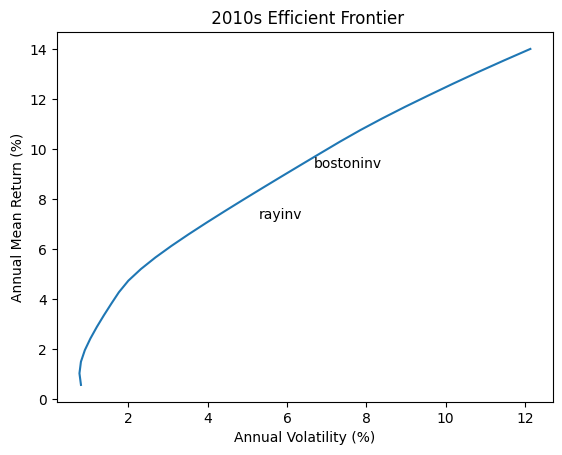

In [ ]:
ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)

ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annual Mean Return (%)')
plt.xlabel('Annual Volatility (%)')
plt.title(
    f' 2010s Efficient Frontier'
)

for t, x, y in zip(
    data_2010.columns,
    data_2010.std().mul(100),
    data_2010.mean().mul(100)
):
    plt.annotate(text=t, xy=(x, y))

plt.show()